In [13]:
# --------------------------------------------------
# Import Libraries and Set Up Environment
# --------------------------------------------------
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

# Enable inline plotting
%matplotlib inline

# matplotlib.use('Agg')  # Use 'Agg' backend

# Set joblib temporary directory
os.environ['JOBLIB_TEMP_FOLDER'] = '/home/nrelab-titan/Desktop/shovon/temp_joblib'

In [14]:
# --------------------------------------------------
# Load and Prepare Data
# --------------------------------------------------
# File paths
# plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/plain_terrain_features.csv'
# grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/grass_terrain_features.csv'

# Noisy csv files' directory
plain_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/noisy_csv_files/plain_terrain_features_10_mm.csv'
grass_terrain_file = '/home/nrelab-titan/Desktop/shovon/data/terrain_analysis/noisy_csv_files/grass_terrain_features_10_mm.csv'

# Load CSV files
plain_terrain_df = pd.read_csv(plain_terrain_file)
grass_terrain_df = pd.read_csv(grass_terrain_file)

plain_terrain_df['label'] = 'plain'
grass_terrain_df['label'] = 'grass'

# Concatenate the DataFrames
combined_df = pd.concat([plain_terrain_df, grass_terrain_df], ignore_index=True)

# Verify the combined DataFrame
print(combined_df.head())


         X         Y         Z   NormalX   NormalY   NormalZ  Intensity  label
0  1.96779  0.191332 -0.657730  0.130649 -0.054538  0.989927       36.0  plain
1  1.81171 -0.253824 -0.650566  0.029475 -0.065517  0.997416       36.0  plain
2  1.93028 -0.067340 -0.653311  0.071199 -0.058897  0.995722       35.0  plain
3  1.73905 -0.223072 -0.646150  0.021972 -0.047431  0.998633       38.0  plain
4  1.95094 -0.090305 -0.648428  0.080604 -0.071769  0.994159       36.0  plain


In [15]:
# --------------------------------------------------
# Feature Extraction and Scaling
# --------------------------------------------------
# Features and labels
features = ['NormalX', 'NormalY']
X = combined_df[features]
y = combined_df['label'].map({'plain': 0, 'grass': 1})

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# --------------------------------------------------
# Feature Visualization before Model Training
# --------------------------------------------------
# Scatter plot of NormalX vs. NormalY
plt.figure(figsize=(12, 8))
sns.scatterplot(x='NormalX', y='NormalY', hue='label', data=combined_df, palette={'plain': 'blue', 'grass': 'green'}, alpha=0.6, s=50)

# Add plot details
plt.title('Scatter Plot of NormalX vs. NormalY')
plt.xlabel('NormalX')
plt.ylabel('NormalY')
plt.legend(title='Terrain Type')
plt.grid(True)

# Show the plot
plt.show()

/tmp/ipykernel_33965/792979784.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [12]:
# --------------------------------------------------
# Model Training and Cross-Validation
# --------------------------------------------------
# Initialize the SVM model with specified parameters
svm_model = SVC(kernel='rbf', C=100, gamma=0.1, verbose=True)

# Perform 10-fold cross-validation with parallel processing
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def parallel_cross_val_predict(estimator, X, y, cv, method='predict'):
    with parallel_backend('loky'):
        return cross_val_predict(estimator, X, y, cv=cv, method=method, n_jobs=-1)

# Using parallel processing for cross_val_predict
y_pred = parallel_cross_val_predict(svm_model, X_scaled, y, skf)
y_decision = parallel_cross_val_predict(svm_model, X_scaled, y, skf, method='decision_function')

# Calculate accuracy metrics
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)

# Display metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Generate a detailed classification report
class_report = classification_report(y, y_pred, target_names=['plain', 'grass'])
print("Classification Report:")
print(class_report)

NameError: name 'SVC' is not defined

In [5]:
# --------------------------------------------------
# Calculate and Print Metrics
# --------------------------------------------------
# Calculate metrics
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_decision)

# Compute TPR, FPR
fpr, tpr, thresholds = roc_curve(y, y_decision)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate additional metrics
tpr_value = tp / (tp + fn)  # True Positive Rate (Recall)
fpr_value = fp / (fp + tn)  # False Positive Rate

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"AUC: {roc_auc}")
print(f"TPR: {tpr_value}")
print(f"FPR: {fpr_value}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['plain', 'grass']))


Accuracy: 0.9947625077986523
F1 Score: 0.9954330249803309
AUC: 0.9998428362362751
TPR: 0.994548437287681
FPR: 0.004949144899762543

Confusion Matrix:
[[ 820908    4083]
 [   6058 1105183]]

Classification Report:
              precision    recall  f1-score   support

       plain       0.99      1.00      0.99    824991
       grass       1.00      0.99      1.00   1111241

    accuracy                           0.99   1936232
   macro avg       0.99      0.99      0.99   1936232
weighted avg       0.99      0.99      0.99   1936232



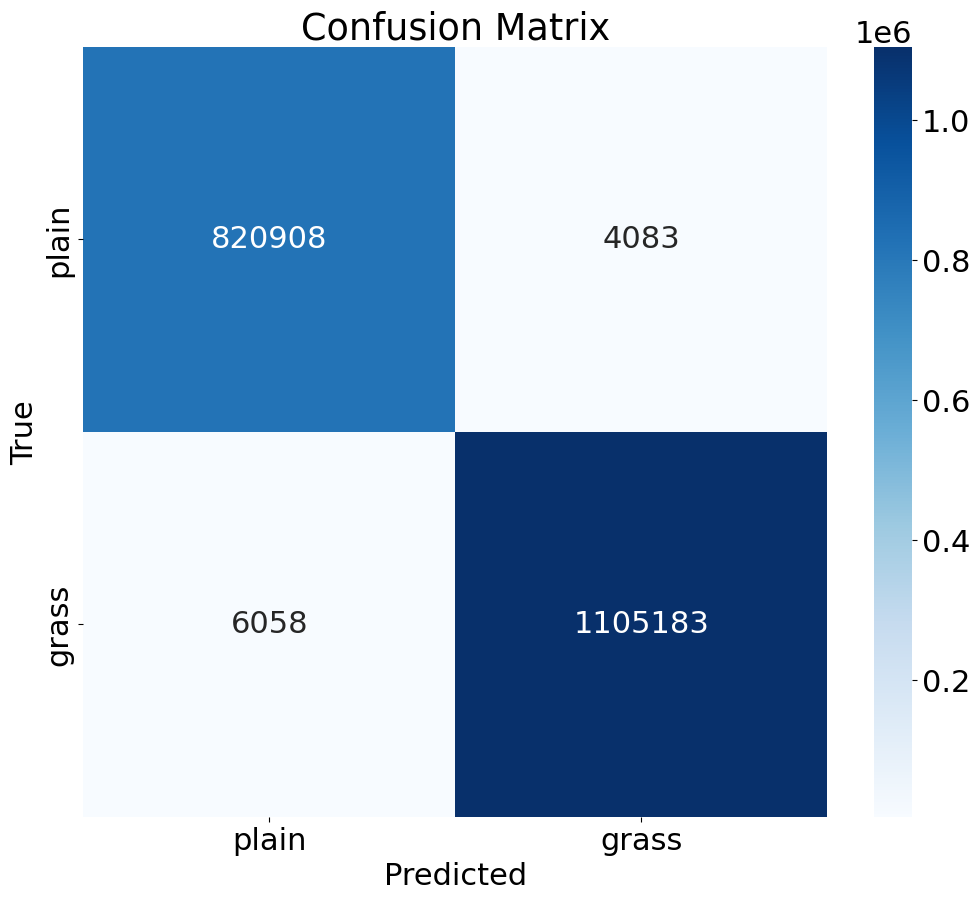

In [6]:
# --------------------------------------------------
# Plot Confusion Matrix
# --------------------------------------------------

# Set the directory where you want to save the plots
plot_save_dir = '/home/nrelab-titan/Desktop/shovon/plots/'

# Ensure the directory exists
os.makedirs(plot_save_dir, exist_ok=True)

# Increase text size for plots
plt.rcParams.update({'font.size': 22})

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['plain', 'grass'], yticklabels=['plain', 'grass'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
confusion_matrix_path = os.path.join(plot_save_dir, 'confusion_matrix.png')
plt.savefig(confusion_matrix_path)

# Show the plot
plt.show()

print(f"Confusion matrix plot saved to: {confusion_matrix_path}")

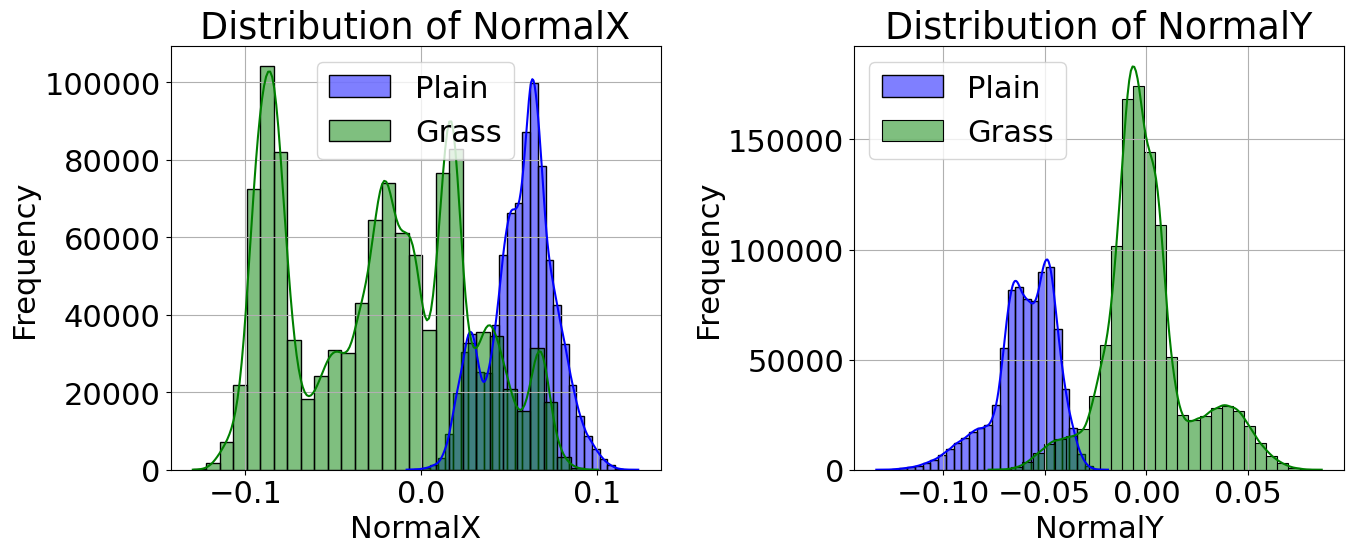

In [7]:
# Plot side by side histograms for NormalX
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(plain_terrain_df['NormalX'], kde=True, bins=30, color='blue', label='Plain')
sns.histplot(grass_terrain_df['NormalX'], kde=True, bins=30, color='green', label='Grass')
plt.title('Distribution of NormalX')
plt.xlabel('NormalX')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Plot side by side histograms for NormalY
plt.subplot(1, 2, 2)
sns.histplot(plain_terrain_df['NormalY'], kde=True, bins=30, color='blue', label='Plain')
sns.histplot(grass_terrain_df['NormalY'], kde=True, bins=30, color='green', label='Grass')
plt.title('Distribution of NormalY')
plt.xlabel('NormalY')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


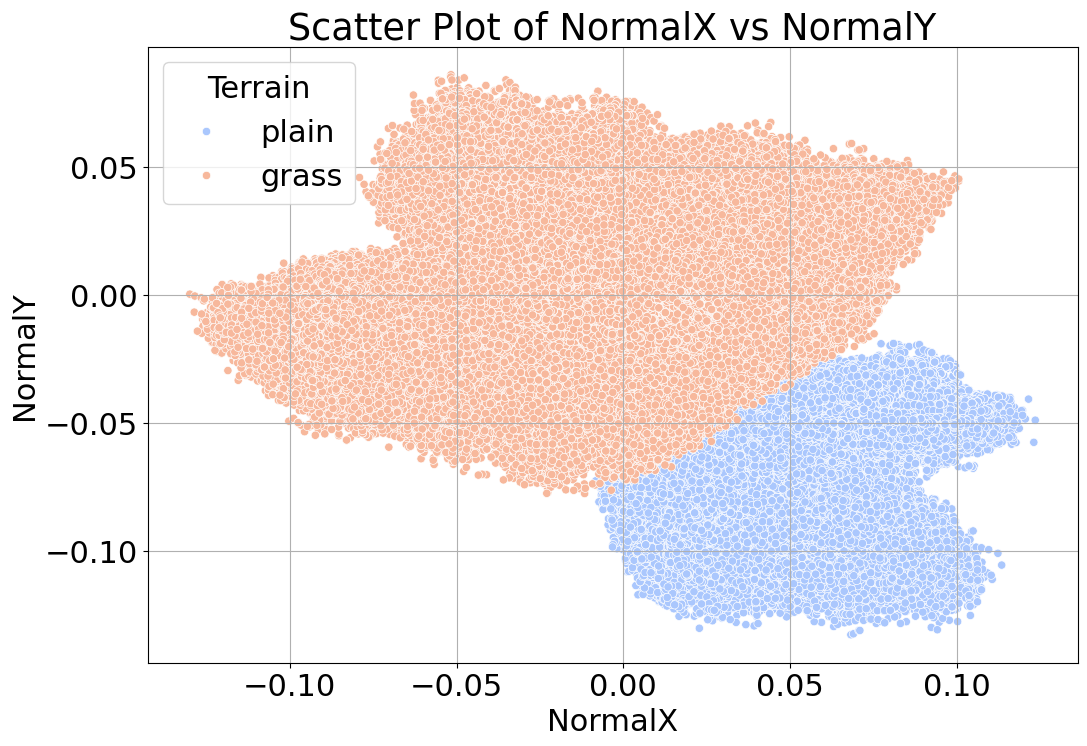

In [8]:
# Scatter Plot for NormalX vs NormalY
plt.figure(figsize=(12, 8))
sns.scatterplot(x='NormalX', y='NormalY', hue='label', data=combined_df, palette='coolwarm')
plt.title('Scatter Plot of NormalX vs NormalY')
plt.xlabel('NormalX')
plt.ylabel('NormalY')
plt.legend(title='Terrain')
plt.grid(True)
plt.show()